**Name:** Luk Wing San (20193803), Gao Shenlai(20256746), Cheung Tin Yan (20197342)

**Math 4432: Project 3 Report Summary**

**Problem chosen:** Nexperia Predictive Maintenance Full 1

**Question proposed:** Which features may be more important than others for predicting failure? Which model may perform better?

**Goal:** Build a good prediction model with high area-under-curve (it is evaluated by Kaggle)

**Contributions:** Luk Wing San 1/3, Gao Shenlai 1/3, Timothy Cheung 1/3

Conclusion: We found that among all of the features, 136222210 and 136224578 may be the most important two types of errors and we get our best result around 0.55344 through logistic regression. We rank 1st in Nexperia Predictive Maintenance Full 1. (account name: Luk Wing San)

### Import Libraries

In [186]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import datetime

from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn.cross_validation import KFold
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

%matplotlib inline

### Simple Helpful Functions and a Little Preprocessing for Neat Data

Basically, we set the Label to be 0 or 1 and merge the top three header rows to make our dataset look more neat.
Other helpful functions are designed to help process or evaluate result.

In [187]:
def getData(path, mode='train'):
    df = pd.read_csv(path, dtype = str, header=[0,1], skiprows = [2])
#     print(df.columns.values)
    df.columns = ['_'+'_'.join(tup).rstrip('_')+'_' for tup in df.columns.values]
    df = df.rename(columns = {'_Unnamed: 0_level_0_Unnamed: 0_level_1_':'Machine', '_Unnamed: 1_level_0_Unnamed: 1_level_1_':'Date', '_Label_Unnamed: 83_level_1_': 'Label'})
    if mode == 'train':
        # some rows in training data doesn't have the label so we drop them
        df = df.dropna(subset=['Label'])
        label = [1 if l == 'True' else 0 for l in df['Label']]
        df['Label'] = label
    df = df.fillna(0)
    return df
def get_roc_and_area(predictions_test, outcome_test):
    fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
def writecsv (ypred, data, file_name):
    date=data['_Unnamed: 1_Unnamed: 2_level_1_'].copy()
    date=[datetime.datetime.strptime(d, "%Y-%m-%d" ).date().strftime("%d/%m/%Y") for d in date]
    submission = pd.DataFrame({
        "id": data["_Unnamed: 0_Unnamed: 1_level_1_"]+'-'+date,
        "Label": ypred
    })
    submission.to_csv(file_name, sep=',', index=False)
def measureResult (ypred, ytest, Logging=True):
    mse = np.mean((ytest - ypred)**2)
    accuracy = np.mean(ytest == ypred)
    Survived_mean=np.mean(ytest)
    uss=np.mean((ytest - ypred)**2)
    dss=np.mean((ytest - Survived_mean)**2)
    r2 = 1-uss/dss
    if Logging:
        print('mse ', mse)
        print('accuracy', accuracy)
        print('R2', r2)
    return mse, accuracy, r2

### a Little Exploration

In [188]:
train = getData('data/full1_upload/training_data/Training freq 1D, OW 16, PW 1.csv')
train.head()

,Machine,Date,_1_count_,_1_vMean_,_1_vStd_,_136088194_count_,_136088194_vMean_,_136088194_vStd_,_136088202_count_,_136088202_vMean_,...,_136676698_count_,_136676698_vMean_,_136676698_vStd_,_136676714_count_,_136676714_vMean_,_136676714_vStd_,_136676754_count_,_136676754_vMean_,_136676754_vStd_,Label
0,M040_A1,2015-06-14,23.0,54841.31988631818,121741.39883332458,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M040_A1,2015-06-15,12.0,51813.133727,67261.98452681443,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M040_A1,2015-06-16,12.0,51813.133727,67261.98452681443,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M040_A1,2015-06-17,13.0,81078.73184941667,116483.42192648024,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M040_A1,2015-06-18,14.0,78175.95402199999,112364.49123839459,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we want to know the count status in the dataset.
(1) for each different label, we sum the count feature for each of them. (2) for each different label, we count how many count features are bigger than 0 (that error occurs) for each of the count feature (3) similar to (1) but we also do it for every machine
We found that for most of the features, the ratio of the statistics of positive label over the statistics of negative label is around 0.1 without much vary, but some of them have significantly higher or lower ratio. And we also noticed that some of the features rarely appear for most of the machine.
To find the most important feature and reduce the dimensionality of the dataset, we use random forest as the analytic helper.

In [189]:
def explore(data):
    # total count for each of the count feature for different label
    countDict1 = {}
    countDict0 = {}
    for col in data.columns:
        if col.find('count') != -1:
            m = data[data['Label']==1][col]
            mFloat = [float(v) for v in m.values]
            countDict1[col] = np.sum(mFloat)
            m = data[data['Label']==0][col]
            mFloat = [float(v) for v in m.values]
            countDict0[col] = np.sum(mFloat)
    for key in countDict1:
        # the count feature, count for label 0, count for label 1, ratio
        print(key, countDict1[key], countDict0[key], countDict1[key]/countDict0[key], end='\n')
        
    appeared = {}
    for col in data.columns:
        if col.find('count') != -1:
            m = data[data['Label']==1][col]
            mFloat = [float(v) for v in m.values]
            k = []
            for v in mFloat:
                k.append(v > 0)

            m = data[data['Label']==0][col]
            mFloat = [float(v) for v in m.values]
            k2 = []
            for v in mFloat:
                k2.append(v > 0)
            # for each count feature, how many of it is larger than 0 for different labels
            appeared[col] = [np.sum(k), np.sum(k2), np.sum(k)/np.sum(k2)]
    for key in appeared:
        print(key, appeared[key])

    # total count for each of the count feature for different label for each machine
    machines = np.unique(data['Machine'])
    for machine in machines:
        machineRecords = data[data['Machine']==machine]

        days = machineRecords['Machine'].count()
        
        countDict1 = {}
        countDict0 = {}
        for col in machineRecords.columns:
            if col.find('count') != -1:
                m = machineRecords[machineRecords['Label']==1][col]
                mFloat = [float(v) for v in m.values]
                countDict1[col] = np.sum(mFloat)
                m = machineRecords[machineRecords['Label']==0][col]
                mFloat = [float(v) for v in m.values]
                countDict0[col] = np.sum(mFloat)

        print(machine)
        print(days, ' days')
        for key in countDict1:
            print(key, countDict1[key], countDict0[key], countDict1[key]/countDict0[key], end='\n')
explore(train)

_1_count_ 22742.0 232382.0 0.09786472274100404
_136088194_count_ 10735.0 112576.0 0.0953578027288232
_136088202_count_ 3476.0 32595.0 0.10664212302500384
_136088394_count_ 3530.0 35999.0 0.0980582793966499
_136088802_count_ 5661.0 55397.0 0.10218964925898515
_136089546_count_ 5750.0 54202.0 0.10608464632301391
_136110468_count_ 6415121.0 99522253.0 0.0644591617113009
_136216674_count_ 2398.0 26836.0 0.08935757937099419
_136222202_count_ 76337.0 867831.0 0.08796297896710305
_136222210_count_ 36205.0 421537.0 0.08588807150973699
_136222234_count_ 2133.0 19676.0 0.10840618011791014
_136222250_count_ 7585.0 76438.0 0.09923074910384887
_136222882_count_ 5518.0 58523.0 0.09428771594074124
_136223186_count_ 8861.0 91025.0 0.09734688272452623
_136224578_count_ 352050.0 3389870.0 0.10385354010625776
_136224586_count_ 245873.0 2721246.0 0.09035309560399905
_136224978_count_ 7883.0 92256.0 0.08544701699618452
_136225010_count_ 546696.0 10735509.0 0.05092408753045617
_136675426_count_ 5163.0 61074

/Users/lukwingsan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


 0.19148936170212766
_136222202_count_ 5963.0 75056.0 0.07944734598166703
_136222210_count_ 4909.0 50450.0 0.09730426164519326
_136222234_count_ 71.0 1635.0 0.04342507645259939
_136222250_count_ 475.0 5670.0 0.0837742504409171
_136222882_count_ 786.0 9796.0 0.08023683135973866
_136223186_count_ 504.0 6397.0 0.0787869313740816
_136224578_count_ 26850.0 324274.0 0.08280034785397535
_136224586_count_ 30381.0 310985.0 0.0976928147659855
_136224978_count_ 150.0 4770.0 0.031446540880503145
_136225010_count_ 25937.0 463963.0 0.05590316469201208
_136675426_count_ 342.0 3304.0 0.10351089588377724
_136675626_count_ 0.0 0.0 nan
_136676578_count_ 132.0 1604.0 0.08229426433915212
_136676650_count_ 135.0 649.0 0.20801232665639446
_136676666_count_ 0.0 0.0 nan
_136676682_count_ 0.0 0.0 nan
_136676698_count_ 0.0 0.0 nan
_136676714_count_ 0.0 0.0 nan
_136676754_count_ 0.0 0.0 nan
M040_A3
982  days
_1_count_ 804.0 6365.0 0.12631578947368421
_136088194_count_ 927.0 10636.0 0.08715682587438887
_136088202_

_136676578_count_ 48.0 1206.0 0.03980099502487562
_136676650_count_ 57.0 615.0 0.09268292682926829
_136676666_count_ 0.0 0.0 nan
_136676682_count_ 0.0 0.0 nan
_136676698_count_ 0.0 0.0 nan
_136676714_count_ 0.0 0.0 nan
_136676754_count_ 0.0 0.0 nan
M044_A1
974  days
_1_count_ 2858.0 24032.0 0.11892476697736351
_136088194_count_ 2934.0 23492.0 0.1248935807934616
_136088202_count_ 1117.0 7811.0 0.14300345666367942
_136088394_count_ 38.0 113.0 0.336283185840708
_136088802_count_ 675.0 5871.0 0.11497189575881452
_136089546_count_ 342.0 1963.0 0.17422312786551197
_136110468_count_ 313450.0 8715752.0 0.035963620809770634
_136216674_count_ 53.0 109.0 0.48623853211009177
_136222202_count_ 6961.0 62766.0 0.11090399260746264
_136222210_count_ 6066.0 74246.0 0.08170137111763597
_136222234_count_ 168.0 1448.0 0.11602209944751381
_136222250_count_ 257.0 1919.0 0.13392391870766024
_136222882_count_ 584.0 6614.0 0.08829755065013607
_136223186_count_ 2008.0 16846.0 0.11919743559301911
_136224578_count

here we build a random forest model for all of the features

In [190]:
# build a random forest model
def RandomForestModel (train_X, train_y, num_estimator):
    randomforest = RandomForestClassifier(n_estimators=num_estimator)
    randomforest.fit(train_X, train_y)
    return randomforest
def processData (data):
    newData = pd.DataFrame()
    for col in data.columns:
        if col not in ['Label','Machine','Date']:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
    # todo: values for different machine should not be in the same line
    newData = newData.fillna(0)

    return newData

633 9000 0.07033333333333333
219 2538 0.08628841607565012
0.04044444444444444 0.9595555555555556 0.38145626267039723


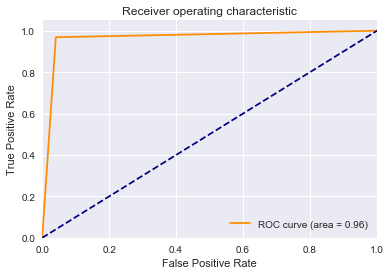

0.12056737588652482 0.8794326241134752 -0.5292137021743935


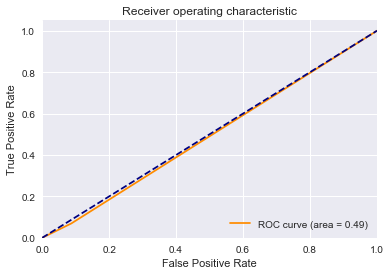

In [191]:
train = getData('data/full1_upload/training_data/Training freq 1D, OW 16, PW 1.csv')
verification = getData('data/full1_upload/test_feature/Verification freq 1D, OW 16, PW 1_feature.csv', 'test')
ptrain = processData(train)
pverification = processData(verification)
                
dataX = ptrain.copy()
datay = train['Label'].copy()

train_X = (dataX[0:9000])
train_y = datay[0:9000]
test_X = (dataX[9001:len(dataX)])
test_y = datay[9001:len(datay)]

print(np.sum(train_y), len(train_y), np.sum(train_y)/len(train_y))
print(np.sum(test_y), len(test_y), np.sum(test_y)/len(test_y))

random_forest = RandomForestModel(train_X, train_y, 2)
y_pred = random_forest.predict(train_X)
mse, acc, r2 = measureResult(y_pred, train_y, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, train_y)

y_pred = random_forest.predict(test_X)
mse, acc, r2 = measureResult(y_pred, test_y, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, test_y)

243 243


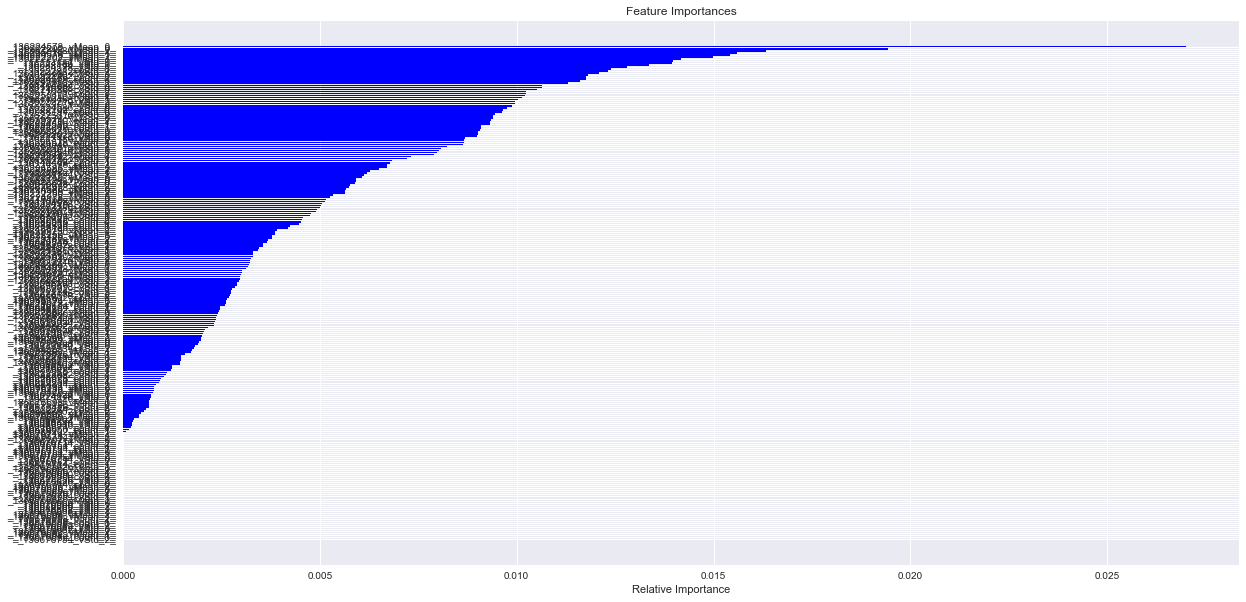

Index(['_136110468_count_0_', '_136222202_vStd_2_', '_136224586_vMean_1_',
       '_136224578_count_0_', '_136223186_count_2_', '_136222202_vStd_0_',
       '_136110468_vMean_1_', '_136222882_vStd_2_', '_1_count_0_',
       '_136224578_vStd_1_', '_136088194_vStd_0_', '_136224586_vStd_1_',
       '_1_vStd_0_', '_136222202_vMean_1_', '_136222202_vMean_2_',
       '_136224578_vMean_1_', '_136225010_vMean_1_', '_136224586_vStd_2_',
       '_136222202_vMean_0_', '_136224578_vMean_0_'],
      dtype='object')


In [195]:
features_names = train_X.columns
importances = random_forest.feature_importances_
print(len(importances), len(features_names))
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features_names[indices])
plt.xlabel('Relative Importance')
plt.show()
print(features_names[indices[len(indices)-20:len(indices)]])

### Logitstic Regression with Label Weights

Here is basically the same as the part of "Logitstic Regression with Label Weights" in our project report for Nexperia Predictive Maintenance Contest (Mini). The only difference is that for the training feature we only choose the counts of 136222210 and 136224578. We have tried many different combinations of features, like means and standard deviation of different errors. It comes out that the counts of 136222210 and 136224578 used for training our model can give the highest accuracy on Kaggle after submission. Also, logitic regression can give highest score on Kaggle comparing to SVM and Random Forest.

In [24]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)

    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.4f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.4f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.4f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.4f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.4f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    plt.tight_layout()
    plt.show()
    return (tp / (tp+fn+0.))
def get_roc_and_area(predictions_test, outcome_test):
    fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    




In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


def train_and_calibrate_cv(model, X_tr, y_tr,cv):
    from sklearn.model_selection import StratifiedKFold
    y_pred_xval = np.zeros(len(y_tr))
    skf = StratifiedKFold(cv,shuffle=True)
    total=0;
    i = 0;
    #Maxmodel;
    MaxTruePositive=0;
    for train, test in skf.split(X_tr,y_tr):
        average=0
        i = i+1
        print("training fold {} of {}".format(i, cv))
        X_train_xval = np.array(X_tr)[train,:]
        X_test_xval = np.array(X_tr)[test,:]
        y_train_xval = np.array(y_tr)[train]
        y_test_xval=np.array(y_tr)[test]
        # We could also copy the model first and then fit it
       # model_copy = model
       # class_Weight = class_weight.compute_class_weight('balanced',np.unique(y_train_xval),y_train_xval)
        model.fit(X_train_xval,y_train_xval)
        #confusion_matrix(y_true, y_pred)
        C = confusion_matrix(y_test_xval, model.predict(X_test_xval))
        #np.set_printoptions(precision=2)
        #plt.figure()
        #plot_confusion_matrix(C, classes= y_tr,title='Confusion matrix, without normalization')
        #plt.show()
        average=show_confusion_matrix(C, ['No Failure', 'Failure'])
        get_roc_and_area(model.predict(X_test_xval), y_test_xval)
        if (average>MaxTruePositive):
            MaxTruePositive=average
            Maxmodel=model
        total = average + total
        #print(test)
        #print(train)
        #y_pred_xval[test]=model.predict_proba(X_test_xval)[:,1]
    print("average true positive rate:" ,total/cv)
    print("Maximum true positive rate:",MaxTruePositive)
    print("training full model")
    #model_copy = model
    #model.fit(X_tr,y_tr)
    #print("calibrating function")
    #calib_func = prob_calibration_function(y_tr, y_pred_xval)
    #test1
    #C = confusion_matrix(y_test_xval, Maxmodel.predict(X_test_xval))
    #show_confusion_matrix(C, ['Not Trend', 'Trend'])
    #get_roc_and_area(Maxmodel.predict(X_test_xval), y_test_xval)
    #print(X_test_xval)
    #print(model.predict(X_test_xval))
    #print(y_test_xval)
    return Maxmodel,test, train
    
#logisticRegr = LogisticRegression() 
#model, test, train = train_and_calibrate_cv(logisticRegr,df[training_features],df[target],10)
#for i in test:
#    model.predict(df.loc(i))
#print(model.predict(X_test_xval))
#print(y_test_xval)
#df['y_hats'] = y_hats.reset_index()[target]

In [120]:
def processNew_Data (data):
    newData = pd.DataFrame()
    newData['Machine']=data['Machine']
    newData['Date']=data['Date']
    for col in data.columns:
        if col not in ['Label','Machine','Date']:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
            
    # todo: values for different machine should not be in the same line
        
    newData = newData.fillna(0)
    arr=np.sum(newData.values[:,2:].astype(float), axis=1)
    newData['totalCount'] = arr
    newData['Label']=data['Label']
    
    return newData
newtrain = processNew_Data(train)
newtrain.head()


,Machine,Date,_1_count_0_,_1_count_1_,_1_count_2_,_1_vMean_0_,_1_vMean_1_,_1_vMean_2_,_1_vStd_0_,_1_vStd_1_,...,_136676754_count_1_,_136676754_count_2_,_136676754_vMean_0_,_136676754_vMean_1_,_136676754_vMean_2_,_136676754_vStd_0_,_136676754_vStd_1_,_136676754_vStd_2_,totalCount,Label
0,M040_A1,2015-06-14,23.0,0,0,54841.31988631818,0,0,121741.39883332458,0,...,0,0,0,0,0,0,0,0,1.624724e+06,0
1,M040_A1,2015-06-15,12.0,23.0,0,51813.133727,54841.31988631818,0,67261.98452681443,121741.39883332458,...,0,0,0,0,0,0,0,0,3.035418e+06,0
2,M040_A1,2015-06-16,12.0,12.0,23.0,51813.133727,51813.133727,54841.31988631818,67261.98452681443,67261.98452681443,...,0,0,0,0,0,0,0,0,4.495723e+06,0
3,M040_A1,2015-06-17,13.0,12.0,12.0,81078.73184941667,51813.133727,51813.133727,116483.42192648024,67261.98452681443,...,0,0,0,0,0,0,0,0,4.412408e+06,0
4,M040_A1,2015-06-18,14.0,13.0,12.0,78175.95402199999,81078.73184941667,51813.133727,112364.49123839459,116483.42192648024,...,0,0,0,0,0,0,0,0,4.539439e+06,0


In [27]:
newtrain['Label'].describe()



count    11683.000000
mean         0.074467
std          0.262541
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Label, dtype: float64

In [28]:
newtrain.groupby('Label').size()

Label
0    10813
1      870
dtype: int64

In [29]:
list(newtrain)

['Machine',
 'Date',
 '_1_count_0_',
 '_1_count_1_',
 '_1_count_2_',
 '_1_vMean_0_',
 '_1_vMean_1_',
 '_1_vMean_2_',
 '_1_vStd_0_',
 '_1_vStd_1_',
 '_1_vStd_2_',
 '_136088194_count_0_',
 '_136088194_count_1_',
 '_136088194_count_2_',
 '_136088194_vMean_0_',
 '_136088194_vMean_1_',
 '_136088194_vMean_2_',
 '_136088194_vStd_0_',
 '_136088194_vStd_1_',
 '_136088194_vStd_2_',
 '_136088202_count_0_',
 '_136088202_count_1_',
 '_136088202_count_2_',
 '_136088202_vMean_0_',
 '_136088202_vMean_1_',
 '_136088202_vMean_2_',
 '_136088202_vStd_0_',
 '_136088202_vStd_1_',
 '_136088202_vStd_2_',
 '_136088394_count_0_',
 '_136088394_count_1_',
 '_136088394_count_2_',
 '_136088394_vMean_0_',
 '_136088394_vMean_1_',
 '_136088394_vMean_2_',
 '_136088394_vStd_0_',
 '_136088394_vStd_1_',
 '_136088394_vStd_2_',
 '_136088802_count_0_',
 '_136088802_count_1_',
 '_136088802_count_2_',
 '_136088802_vMean_0_',
 '_136088802_vMean_1_',
 '_136088802_vMean_2_',
 '_136088802_vStd_0_',
 '_136088802_vStd_1_',
 '_136088

training fold 1 of 10


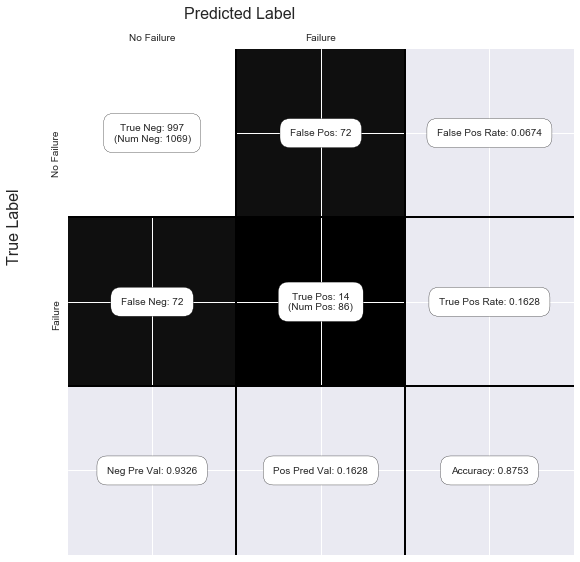

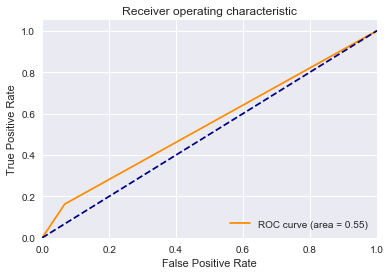

training fold 2 of 10


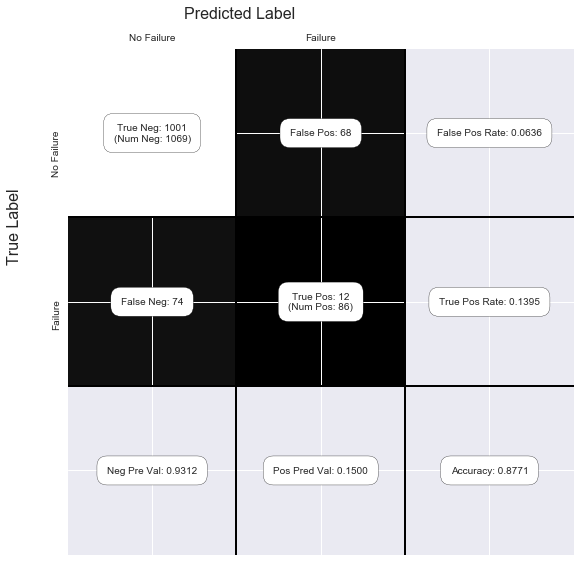

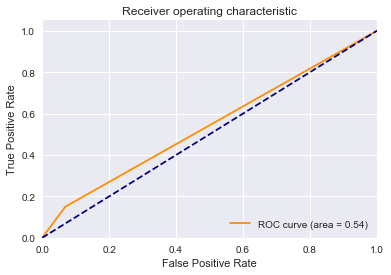

training fold 3 of 10


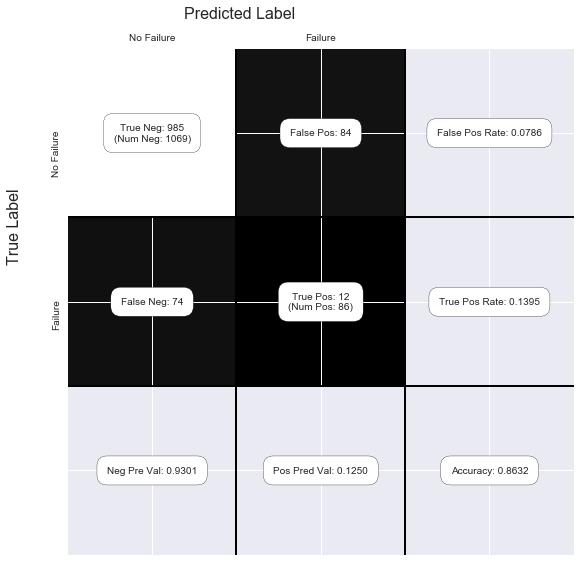

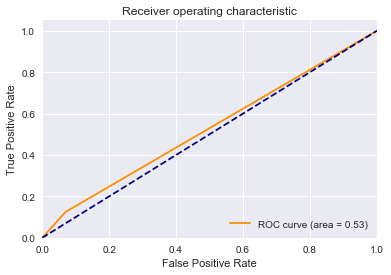

training fold 4 of 10


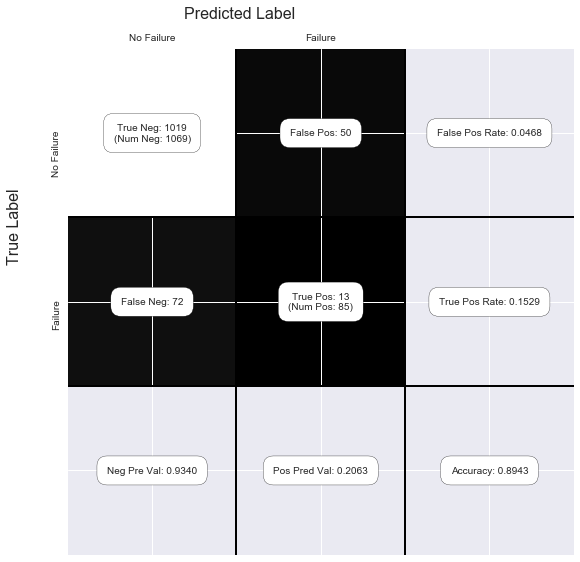

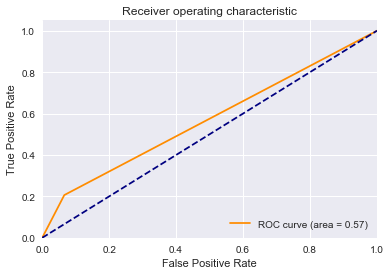

training fold 5 of 10


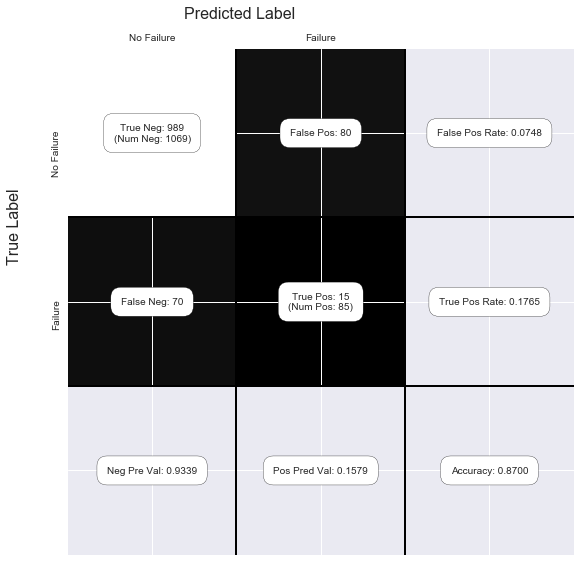

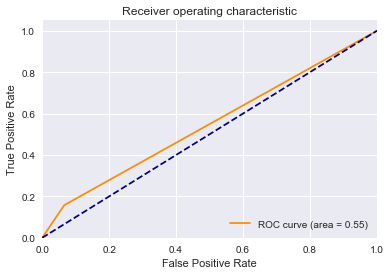

training fold 6 of 10


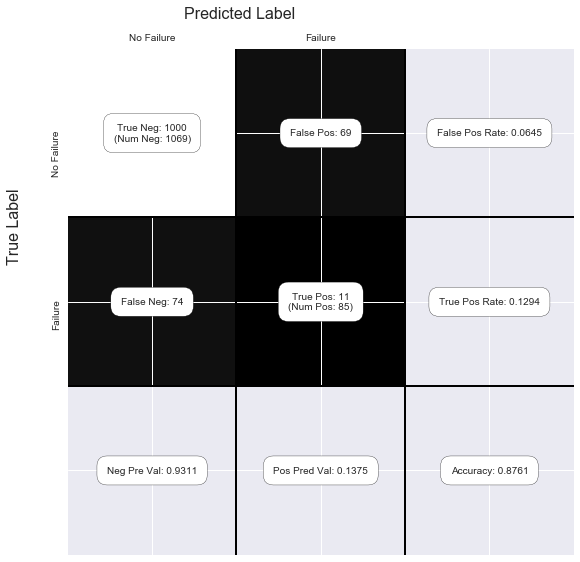

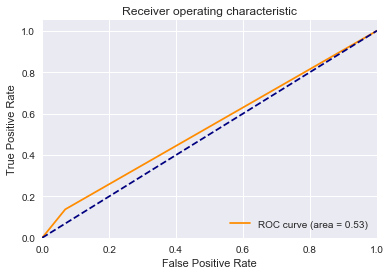

training fold 7 of 10


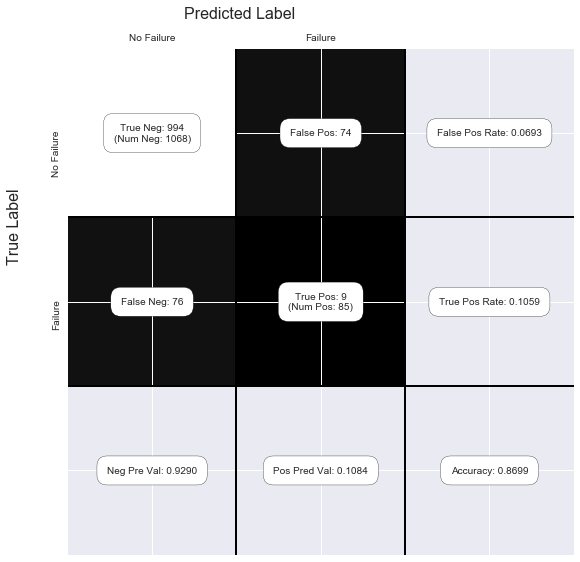

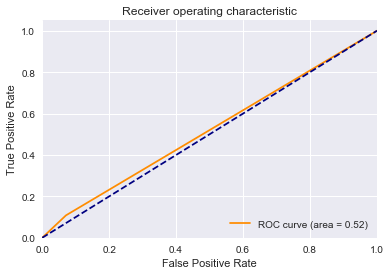

training fold 8 of 10


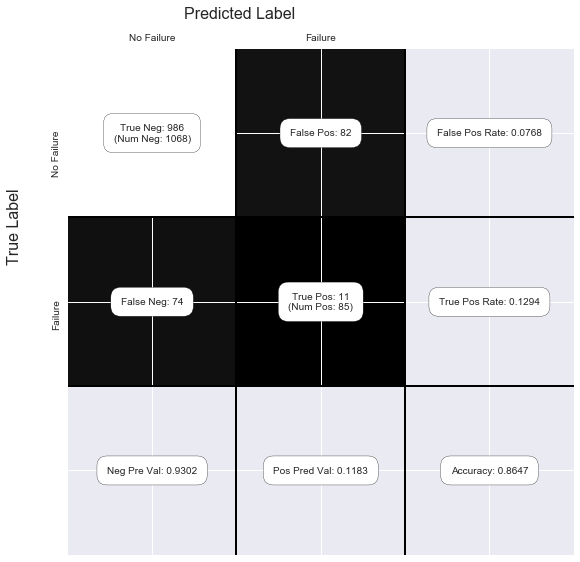

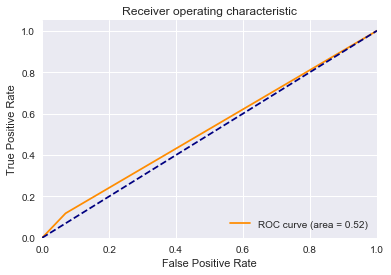

training fold 9 of 10


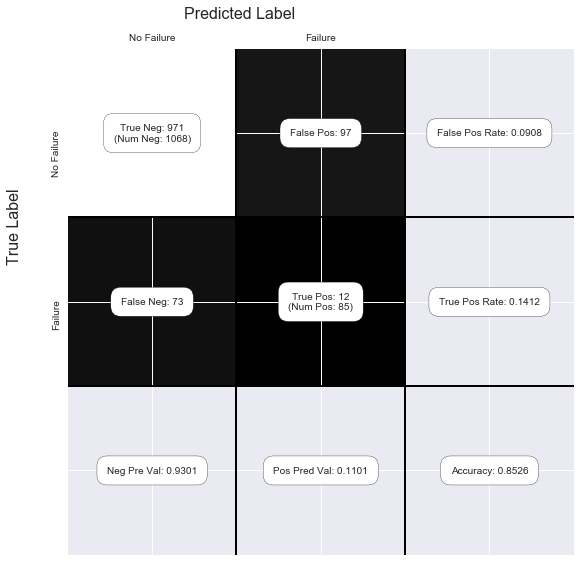

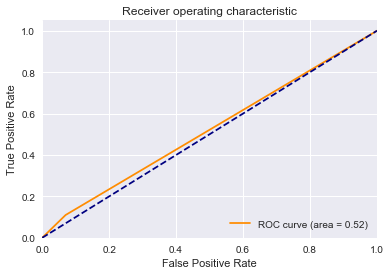

training fold 10 of 10


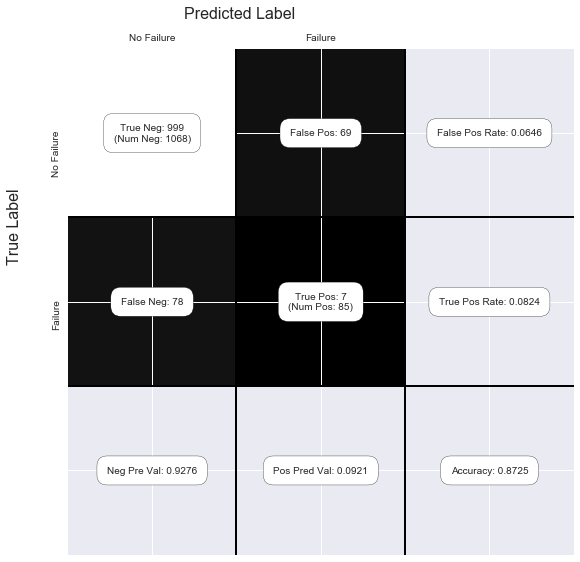

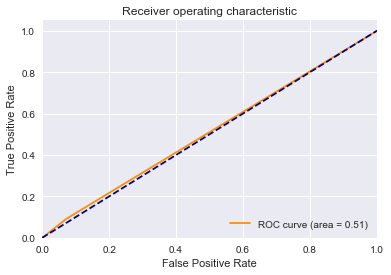

average true positive rate: 0.13595075239398086
Maximum true positive rate: 0.17647058823529413
training full model


In [185]:
'''training_features=['_136222210_count_2_',
           '_136222202_count_1_', '_136222202_count_2_', 
           '_136225010_count_2_', '_136225010_count_1_', '_136224578_count_0_',
           '_136225010_count_0_', '_136222202_count_0_', '_136224586_count_1_',
           '_136224586_count_0_', '_136224578_count_1_', '_136110468_count_2_',
           '_136224578_count_2_', '_136224586_count_2_',
           '_136110468_count_0_']#'_136110468_count_1_'''
training_features=['_136224578_count_1_','_136224578_count_2_','_136224578_count_0_','_136222210_count_0_','_136222210_count_1_','_136222210_count_2_']# '_136224578_count_1_','_136224578_count_2_','_136224578_count_0_',#'_136224578_count_1_',,'_136224578_count_2_''_136224578_count_0_'
target='Label'
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
clf =  LogisticRegression(class_weight={1:10,0:1})
#clf =  SVM() 
#clf =  LogisticRegression()
#clf = DecisionTreeClassifier(class_weight={1:100,0:1})
DMaxmodel, dtest, dtrain = train_and_calibrate_cv(clf,newtrain[training_features],newtrain[target],10)



In [124]:
verification = getData('data/full1_upload/test_feature/Verification freq 1D, OW 16, PW 1_feature.csv', 'test')
verification

,_Unnamed: 0_level_0_0_,_Unnamed: 0_Unnamed: 1_level_1_,_Unnamed: 1_Unnamed: 2_level_1_,_1_count_,_1.1_vMean_,_1.2_vStd_,_136088194_count_,_136088194.1_vMean_,_136088194.2_vStd_,_136088202_count_,...,_136676682.2_vStd_,_136676698_count_,_136676698.1_vMean_,_136676698.2_vStd_,_136676714_count_,_136676714.1_vMean_,_136676714.2_vStd_,_136676754_count_,_136676754.1_vMean_,_136676754.2_vStd_
0,2,M066_A1,2015-06-04,34.0,21386.330814545454,67253.00917259954,11.0,109683.36149810001,170937.01833636157,0,...,0,0,0,0,0,0,0,0,0,0
1,3,M066_A1,2015-06-05,40.0,21126.197103128205,62760.34000069893,11.0,109683.36149810001,170937.01833636157,0,...,0,0,0,0,0,0,0,0,0,0
2,4,M066_A1,2015-06-06,41.0,21527.279331849997,62021.46871279257,10.0,71987.11791844443,135114.77926223856,0,...,0,0,0,0,0,0,0,0,0,0
3,5,M066_A1,2015-06-07,41.0,21527.279331849997,62021.46871279257,11.0,107390.264433,166465.75703655957,0,...,0,0,0,0,0,0,0,0,0,0
4,6,M066_A1,2015-06-08,43.0,25267.86988538095,65268.31440273438,11.0,107390.264433,166465.75703655957,0,...,0,0,0,0,0,0,0,0,0,0
5,7,M066_A1,2015-06-09,43.0,25267.86988538095,65268.31440273438,11.0,107390.264433,166465.75703655957,0,...,0,0,0,0,0,0,0,0,0,0
6,8,M066_A1,2015-06-10,43.0,25267.86988538095,65268.31440273438,11.0,107390.264433,166465.75703655957,0,...,0,0,0,0,0,0,0,0,0,0
7,9,M066_A1,2015-06-11,44.0,30302.97782639535,72288.87394860772,8.0,115973.771225,183605.00909544344,0,...,0,0,0,0,0,0,0,0,0,0
8,10,M066_A1,2015-06-12,28.0,36548.867460037036,62533.90236066054,8.0,115973.771225,183605.00909544344,0,...,0,0,0,0,0,0,0,0,0,0
9,11,M066_A1,2015-06-13,28.0,36548.867460037036,62533.90236066054,8.0,115973.771225,183605.00909544344,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
def processVer_Data (data):
    newData = pd.DataFrame()
    newData['Machine']=data['_Unnamed: 0_Unnamed: 1_level_1_']
    newData['Date']=data['_Unnamed: 1_Unnamed: 2_level_1_']
    for col in data.columns:
        
        if col not in ['_Unnamed: 0_level_0_0_','_Unnamed: 0_Unnamed: 1_level_1_','_Unnamed: 1_Unnamed: 2_level_1_']:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
            
    # todo: values for different machine should not be in the same line
    newData = newData.fillna(0)  
    
    arr=np.sum(newData.values[:,2:].astype(float), axis=1)
    newData['totalCount'] = arr
    
    
    return newData
verification = getData('data/full1_upload/test_feature/Verification freq 1D, OW 16, PW 1_feature.csv', 'test')
newtest = processVer_Data(verification)
newtest

,Machine,Date,_1_count_0_,_1_count_1_,_1_count_2_,_1.1_vMean_0_,_1.1_vMean_1_,_1.1_vMean_2_,_1.2_vStd_0_,_1.2_vStd_1_,...,_136676754_count_0_,_136676754_count_1_,_136676754_count_2_,_136676754.1_vMean_0_,_136676754.1_vMean_1_,_136676754.1_vMean_2_,_136676754.2_vStd_0_,_136676754.2_vStd_1_,_136676754.2_vStd_2_,totalCount
0,M066_A1,2015-06-04,34.0,0,0,21386.330814545454,0,0,67253.00917259954,0,...,0,0,0,0,0,0,0,0,0,1.961195e+06
1,M066_A1,2015-06-05,40.0,34.0,0,21126.197103128205,21386.330814545454,0,62760.34000069893,67253.00917259954,...,0,0,0,0,0,0,0,0,0,4.121391e+06
2,M066_A1,2015-06-06,41.0,40.0,34.0,21527.279331849997,21126.197103128205,21386.330814545454,62021.46871279257,62760.34000069893,...,0,0,0,0,0,0,0,0,0,6.048713e+06
3,M066_A1,2015-06-07,41.0,41.0,40.0,21527.279331849997,21527.279331849997,21126.197103128205,62021.46871279257,62021.46871279257,...,0,0,0,0,0,0,0,0,0,5.988045e+06
4,M066_A1,2015-06-08,43.0,41.0,41.0,25267.86988538095,21527.279331849997,21527.279331849997,65268.31440273438,62021.46871279257,...,0,0,0,0,0,0,0,0,0,5.652813e+06
5,M066_A1,2015-06-09,43.0,43.0,41.0,25267.86988538095,25267.86988538095,21527.279331849997,65268.31440273438,65268.31440273438,...,0,0,0,0,0,0,0,0,0,5.528444e+06
6,M066_A1,2015-06-10,43.0,43.0,43.0,25267.86988538095,25267.86988538095,25267.86988538095,65268.31440273438,65268.31440273438,...,0,0,0,0,0,0,0,0,0,5.345414e+06
7,M066_A1,2015-06-11,44.0,43.0,43.0,30302.97782639535,25267.86988538095,25267.86988538095,72288.87394860772,65268.31440273438,...,0,0,0,0,0,0,0,0,0,5.249103e+06
8,M066_A1,2015-06-12,28.0,44.0,43.0,36548.867460037036,30302.97782639535,25267.86988538095,62533.90236066054,72288.87394860772,...,0,0,0,0,0,0,0,0,0,5.013042e+06
9,M066_A1,2015-06-13,28.0,28.0,44.0,36548.867460037036,36548.867460037036,30302.97782639535,62533.90236066054,62533.90236066054,...,0,0,0,0,0,0,0,0,0,4.817096e+06


In [114]:
DMaxmodel.predict(newtest[training_features])

array([1, 1, 0, ..., 0, 0, 0])

We fit the features of the verification data and make our submission for testing on Kaggle

In [184]:
features=['_136224578_count_1_','_136224578_count_2_','_136224578_count_0_','_136222210_count_0_','_136222210_count_1_','_136222210_count_2_']

In [183]:
writecsv(DMaxmodel.predict(newtest[features]), verification, 'contest40logistic.csv')

### Conclusion
This report takes reference from our report for Nexperia Predictive Maintenance Contest (Mini). The only difference is the change of training and testing dataset. We use the dataset of "16 oberservation windows with 1 prediction window". Moreover, we only focus on logistic regression, random forest and SVM here, unlike that we try several neural network methods in the mini contest report. For the training feature we only choose the counts of 136222210 and 136224578 this time. We have tried many different combinations of features, like means and standard deviation of different errors. It comes out that the counts of 136222210 and 136224578 used for training our model can give the highest accuracy on Kaggle after submission. Also, logitic regression can give highest score on Kaggle comparing to SVM and Random Forest. 